In [1]:
from __future__ import (print_function, absolute_import, division,
                        unicode_literals, with_statement)
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
import numpy as np
from cleanlab.classification import LearningWithNoisyLabels
from cleanlab.noise_generation import generate_noisy_labels
from cleanlab.util import value_counts
from cleanlab.latent_algebra import compute_inv_noise_matrix

`cleanlab` can be used with any classifier and dataset for multiclass
learning with noisy labels. Its comprised of components from the theory and
algorithms of **confident learning**. It's a Python class that wraps around
any classifier as long as .fit(X, y, sample_weight),
.predict(X), .predict_proba(X) are defined.
See https://l7.curtisnorthcutt.com/cleanlab-python-package for docs.


## Here we show the performance with LogisiticRegression classifier
## versus LogisticRegression \*without\* cleanlab on the Iris dataset.

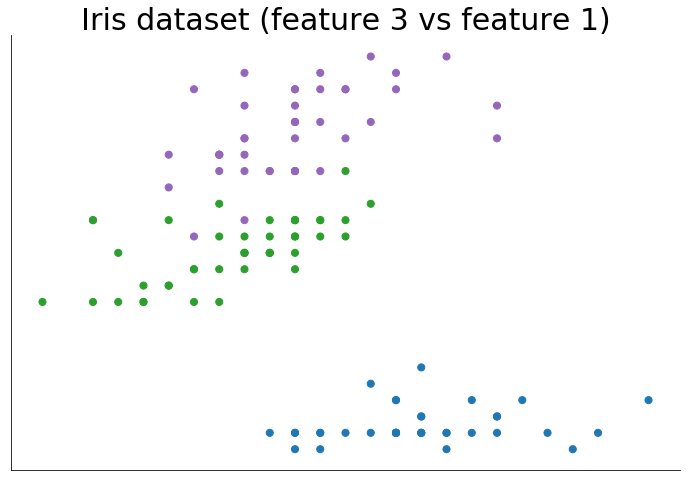

In [2]:
# Seed for reproducibility
seed = 2
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
rp = LearningWithNoisyLabels(clf=clf, seed=seed)
np.random.seed(seed=seed)

# Get iris dataset
iris = datasets.load_iris()
X = iris.data  # we only take the first two features.
y = iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
    from matplotlib import pyplot as plt

    _ = plt.figure(figsize=(12, 8))
    color_list = plt.cm.tab10(np.linspace(0, 1, 6))
    _ = plt.scatter(X_train[:, 1], X_train[:, 3],
                    color=[color_list[z] for z in y_train], s=50)
    ax = plt.gca()
    #     plt.axis('off')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = plt.title("Iris dataset (feature 3 vs feature 1)", fontsize=30)
except Exception as e:
    print(e)
    print("Plotting is only supported in an iPython interface.")

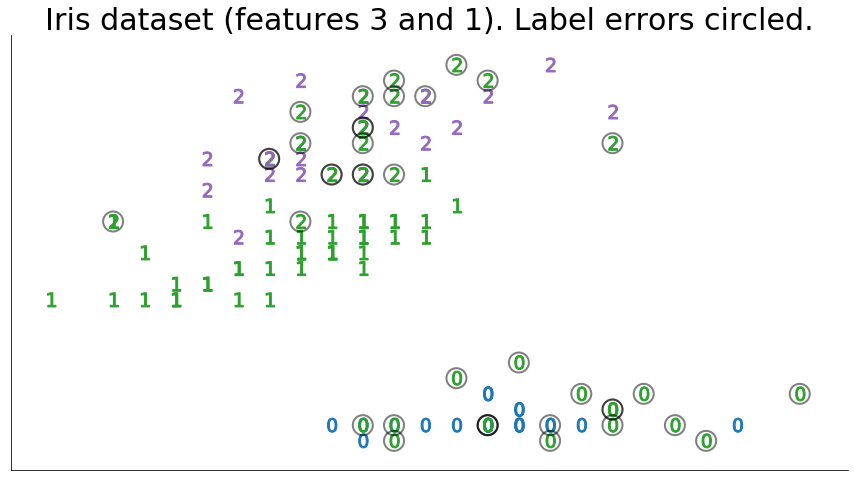

In [3]:
# Generate lots of noise.
noise_matrix = np.array([
    [0.5, 0.0, 0.0],
    [0.5, 1.0, 0.5],
    [0.0, 0.0, 0.5],
])

py = value_counts(y_train)
# Create noisy labels
s = generate_noisy_labels(y_train, noise_matrix)

try:
    get_ipython().run_line_magic('matplotlib', 'inline')
    from matplotlib import pyplot as plt

    _ = plt.figure(figsize=(15, 8))
    color_list = plt.cm.tab10(np.linspace(0, 1, 6))
    for k in range(len(np.unique(y_train))):
        X_k = X_train[y_train == k]  # data for class k
        _ = plt.scatter(
            X_k[:, 1],
            X_k[:, 3],
            color=[color_list[noisy_label] for noisy_label in s[y_train == k]],
            s=200,
            marker=r"${a}$".format(a=str(k)),
            linewidth=1,
        )
    _ = plt.scatter(
        x=X_train[s != y_train][:, 1],
        y=X_train[s != y_train][:, 3],
        color=[color_list[z] for z in s],
        s=400,
        facecolors='none',
        edgecolors='black',
        linewidth=2,
        alpha=0.5,
    )
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    _ = ax.get_xaxis().set_ticks([])
    _ = ax.get_yaxis().set_ticks([])
    _ = plt.title("Iris dataset (features 3 and 1). Label errors circled.",
                  fontsize=30)
except Exception as e:
    print(e)
    print("Plotting is only supported in an iPython interface.")

In [4]:
print('WITHOUT confident learning,', end=" ")
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
_ = clf.fit(X_train, s)
pred = clf.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test), 2))

print("\nNow we show improvement using cleanlab to characterize the noise")
print("and learn on the data that is (with high confidence) labeled correctly.")
print()
print('WITH confident learning (noise matrix given),', end=" ")
_ = rp.fit(X_train, s, noise_matrix=noise_matrix)
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test), 2))

print('WITH confident learning (noise / inverse noise matrix given),', end=" ")
inv = compute_inv_noise_matrix(py, noise_matrix)
_ = rp.fit(X_train, s, noise_matrix=noise_matrix, inverse_noise_matrix=inv)
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test), 2))

print('WITH confident learning noise not given,', end=" ")
clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
rp = LearningWithNoisyLabels(clf=clf, seed=seed)
_ = rp.fit(X_train, s)
pred = rp.predict(X_test)
print("Iris dataset test accuracy:", round(accuracy_score(pred, y_test), 2))

WITHOUT confident learning, Iris dataset test accuracy: 0.6

Now we show improvement using cleanlab to characterize the noise
and learn on the data that is (with high confidence) labeled correctly.

WITH confident learning (noise matrix given), Iris dataset test accuracy: 0.83
WITH confident learning (noise / inverse noise matrix given), Iris dataset test accuracy: 0.83
WITH confident learning noise not given, Iris dataset test accuracy: 0.77


## Performance of confident learning across varying settings.
To learn more, inspect ```cleanlab/pruning.py``` and ```cleanlab/classification.py```.

In [ ]:
param_grid = {
    "prune_method": ["prune_by_noise_rate", "prune_by_class", "both"],
    "converge_latent_estimates": [True, False],
}

# Fit LearningWithNoisyLabels across all parameter settings.
params = ParameterGrid(param_grid)
scores = []
for param in params:
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    rp = LearningWithNoisyLabels(clf=clf, n_jobs=1, **param)
    _ = rp.fit(X_train, s)  # s is the noisy y_train labels
    scores.append(accuracy_score(rp.predict(X_test), y_test))

# Print results sorted from best to least
for i in np.argsort(scores)[::-1]:
    print("Param settings:", params[i])
    print(
        "Iris dataset test accuracy (using confident learning):\t",
        round(scores[i], 2),
        "\n",
    )

In [5]:
param_grid = {
    "prune_method": ["prune_by_noise_rate", "prune_by_class", "both"],
    "converge_latent_estimates": [True, False],
}

# Fit LearningWithNoisyLabels across all parameter settings.
params = ParameterGrid(param_grid)
scores = []
for param in params:
    clf = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000)
    rp = LearningWithNoisyLabels(clf=clf, n_jobs=1, **param)
    _ = rp.fit(X_train, s)  # s is the noisy y_train labels
    scores.append(accuracy_score(rp.predict(X_test), y_test))

# Print results sorted from best to least
for i in np.argsort(scores)[::-1]:
    print("Param settings:", params[i])
    print(
        "Iris dataset test accuracy (using confident learning):\t",
        round(scores[i], 2),
        "\n",
    )

Param settings: {'prune_method': 'prune_by_class', 'converge_latent_estimates': False}
Iris dataset test accuracy (using confident learning):	 0.83 

Param settings: {'prune_method': 'prune_by_class', 'converge_latent_estimates': True}
Iris dataset test accuracy (using confident learning):	 0.83 

Param settings: {'prune_method': 'both', 'converge_latent_estimates': False}
Iris dataset test accuracy (using confident learning):	 0.8 

Param settings: {'prune_method': 'both', 'converge_latent_estimates': True}
Iris dataset test accuracy (using confident learning):	 0.8 

Param settings: {'prune_method': 'prune_by_noise_rate', 'converge_latent_estimates': False}
Iris dataset test accuracy (using confident learning):	 0.77 

Param settings: {'prune_method': 'prune_by_noise_rate', 'converge_latent_estimates': True}
Iris dataset test accuracy (using confident learning):	 0.77 

